In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!RUST_BACKTRACE=1 cargo run -- ../models/quadrotor.mo -t ../templates/sympy.jinja > quadrotor_sympy.py

    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.09s
     Running `/home/jgoppert/git/rumoca_parol/target/debug/rumoca ../models/quadrotor.mo -t ../templates/sympy.jinja`


In [3]:
import quadrotor_sympy
import numpy as np
import matplotlib.pyplot as plt

model = quadrotor_sympy.Model()
model.solve()

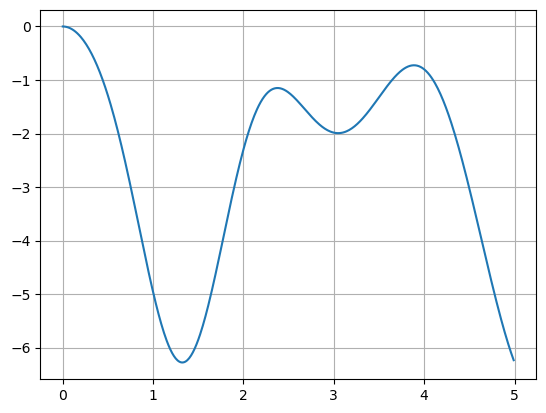

In [4]:
def f_u(t):
    omega = 10
    return np.array([omega, omega, omega, omega])

res = model.simulate(t0=0, tf=5, dt=0.01, f_u=f_u)

plt.figure()
plt.plot(res['t'], res['x'][2, :].T);
#plt.plot(t, u(t).T)
plt.grid()

In [5]:
# linearization
A = model.sol_x_dot.jacobian(model.x).subs(model.x0).subs(model.p0).subs(model.u0)
B = model.sol_x_dot.jacobian(model.u).subs(model.x0).subs(model.p0).subs(model.u0)
C = model.sol_y.jacobian(model.x).subs(model.x0).subs(model.p0).subs(model.u0)
D = model.sol_y.jacobian(model.u).subs(model.x0).subs(model.p0).subs(model.u0)

(A, B, C, D)

(Matrix([
 [0, 0, 0, 0, 0, 0, 1, 0,  0,    0,     1, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0, -1,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0, -9.81, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0, 9.81,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 1, 0, 0, 0, 0,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 1, 0, 0, 0,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 1, 0, 0,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0, -1,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0, -1,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0,  0, -1,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,